In [81]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
from matplotlib import cm
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D  
os.chdir('P:/Alon/MSc/Thesis Backup/Analysis files/Analysis Pipeline 10_04_2020')
from Support import HCP as p
import pickle
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import datetime
import pingouin as pg
from sklearn.linear_model import LinearRegression
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

seasons         = ['Winter','Spring','Summer','Autumn']
model_path      = 'P:/Alon/MSc/Thesis Backup/Analysis files/Analysis Pipeline 10_04_2020/HCP/Stage 4 - Deep learning model/model-dsbowl2018-1.h5'
Manual_in_path  = 'P:/Alon/MSc/Thesis Backup/Analysis files/Analysis Pipeline 10_04_2020/HCP/Stage 3 - Manual segmentation/mat lib/img mat files'
Manual_out_path = 'P:/Alon/MSc/Thesis Backup/Analysis files/Analysis Pipeline 10_04_2020/HCP/Stage 3 - Manual segmentation/mat lib/mask mat files'

In [82]:
#load ROI - 3D tensor of gland specific location from .mat file, raw values from the T1 Weighted MRI scan
def load_ROI(mat_path):
    f = sio.loadmat(mat_path)
   # mat_id  = f['ID'][0]
   # roi_idx = [f['Crop_idx'][0,i] for i in range(3)]
    ROI     = f['ROI']
    return ROI#, roi_idx, mat_id

#load ROI - 3D tensor of gland pixels in the ROI from .mat file, values are binary - 1 is pixel of the gland, 0 is other
def load_mask(gt_path):
    f = sio.loadmat(gt_path)
    mask = f['mask']
    return mask

# metric for U-net algorithem performance (intersection over union)
def mean_iou(y_true, y_pred):
    prec = [] 
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

#visualization of 1 subject gland with u-net estimation, slices and 3d model
    
def slice_qa(ROI,prediction,dims):   
            
    slice_list = [ROI[:,:,i] for i in range(Dims[2])]    
    
    pred_mask       = np.zeros_like(ROI,dtype =int)
    pred_mask[np.dstack(prediction)>0.3] = 1
    pred_mask_list  = [pred_mask[:,:,i] for i in range(Dims[2])]
    
    QA_X   = np.empty((Dims[0]*3,Dims[1]*4))
    QA_Y   = np.empty((Dims[0]*3,Dims[1]*4))

    for col in range(4):
        for row in range(3): 
            QA_X[row*Dims[0]:row*Dims[0]+Dims[0],col*Dims[1]:col*Dims[1]+Dims[1]]   = slice_list[row +col*3]
            QA_Y[row*Dims[0]:row*Dims[0]+Dims[0],col*Dims[1]:col*Dims[1]+Dims[1]]   = prediction[row +col*3]

    QA = np.concatenate((QA_X,QA_Y),axis = 1)
    plt.figure(figsize=(14,20))
    plt.imshow(QA,cmap = 'gray')
    plt.axis('off')
    plt.show()
     
    fc1 = cm.gray(np.transpose(ROI))
    fc2 = cm.viridis(np.transpose(ROI))
    fc1[:,:,:,3] = 0.4
    
    fig2 = plt.figure(figsize=(8,8))
    ax = fig2.gca(projection='3d')
    ax.voxels(np.transpose(ROI),facecolors = fc1)    
    ax.voxels(np.transpose(pred_mask),facecolors = fc2)
    ax.view_init(elev=190., azim=-20)
    plt.title('U-Net prediction')
    plt.axis('off')
    plt.show()

,ID,Release,Acquisition,Gender,Age,date,FS_IntraCranial_Vol,prediction,norm_pituitary,ashape,month,sex,Season,Age_group
0,100610,S900,Q08,M,26-30,'8/29/2015',1.816044e+06,291.224,0.000160,0.001992,8,1,Summer,1
1,102311,S500,Q06,F,26-30,'7/18/2014',1.548451e+06,337.698,0.000218,0.002511,7,0,Summer,1
2,102816,Q3,Q03,F,26-30,'2/20/2015',1.412821e+06,324.622,0.000230,0.002523,2,0,Winter,1
3,104416,S900,Q09,F,31-35,'1/31/2015',1.401212e+06,283.423,0.000202,0.002671,1,0,Winter,2
4,105923,MEG2,Q07,F,31-35,'1/23/2015',1.499697e+06,293.698,0.000196,0.002327,1,0,Winter,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,958976,S500,Q05,M,26-30,'5/29/2015',1.433146e+06,243.304,0.000170,0.002562,5,1,Spring,1
175,966975,S900,Q12,M,22-25,'9/25/2015',1.779612e+06,288.486,0.000162,0.001989,9,1,Autumn,0
176,971160,S1200,Q10,M,26-30,'10/23/2015',1.721742e+06,209.78,0.000122,0.002226,10,1,Autumn,1
177,973770,S1200,Q13,M,22-25,'10/3/2015',1.523394e+06,280.666,0.000184,0.002437,10,1,Autumn,0


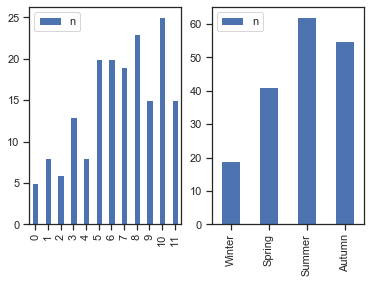

In [83]:
# raw_df = pd.read_excel('.\HCP\HCP_results.xls')
# raw_df['prediction'] = None
# UNET          = load_model(model_path,custom_objects={'mean_iou': mean_iou}) 
# for i in tqdm(range(len(raw_df))):
#     sub_id    = str(raw_df.iloc[i].ID)
#     NII_PATH  = os.path.join(p.ROI_LIB,sub_id,p.generic_filename)
#     MAT_PATH  = Manual_in_path + '/' +  sub_id +'.mat'
#     MASK_PATH = Manual_out_path + '/' + sub_id + '_mask.mat'
#     X         = np.rot90(load_ROI(MAT_PATH))
#     Dims      = np.shape(X)
#     hx        = [np.rot90(np.reshape(UNET.predict(np.reshape(X[:,:,slice],[1,Dims[0],Dims[1],1]), verbose=0),(Dims[0],Dims[1])),k=1,axes=(1,0)) for slice in range(Dims[2])]
#     sio.savemat('P:/Alon/MSc/Thesis Backup/Analysis files/Analysis Pipeline 10_04_2020/HCP/Library/Predictions/' + sub_id + '.mat',{'mask': hx})
#     raw_df.loc[i,['prediction']] = np.sum(hx).astype(float)    

# ashapes = sio.loadmat('P:/Alon/MSc/Thesis Backup/Analysis files/Analysis Pipeline 10_04_2020/HCP/alpha_shapes.mat')
# mat_df  = pd.DataFrame(ashapes['mat_files'],columns=['ID','ashape'])
# raw_df['norm_pituitary'] = (raw_df['prediction']/raw_df['FS_IntraCranial_Vol']).astype(float)
# raw_df['ashape']         = [mat_df['ashape'] [i][0][0] for i in range(len(mat_df))]/raw_df['FS_IntraCranial_Vol']    
        
# raw_df['month']     = [datetime.datetime.strptime(raw_df.date.values[i][1:-1], '%m/%d/%Y').month for i in range(len(raw_df))]
# raw_df.loc[raw_df.month == 12,['month']] = 0
# raw_df['sex']       = (raw_df['Gender'] == 'M')*1
# raw_df['Season']    = [np.array(seasons)[int(np.floor(raw_df.month[i]/3))] for i in range(len(raw_df))]
# raw_df['Age_group'] = 0

# for i,u in enumerate(raw_df['Age'].unique()[[2,0,1,3]]):
#     raw_df.loc[raw_df['Age'] == u ,['Age_group']] = i        
# raw_df = raw_df.loc[raw_df['Age_group']!=3]    
# pickle.dump(raw_df,open('.\HCP\HCP_dataframe_0406.p','wb'))

raw_df = pickle.load(open('.\HCP\HCP_dataframe_0406.p','rb'))
display(raw_df)
n_month_df  = pd.DataFrame([np.sum(raw_df['month']==m) for m in range(12)],index=range(12),columns = ['n'])
n_season_df = pd.DataFrame([np.sum(raw_df['Season']==m) for m in seasons],index=seasons,columns = ['n'])
n_month_df.plot.bar(ax = plt.subplot(121))
n_season_df.plot.bar(ax = plt.subplot(122))

In [84]:
def anova_2way_pituitary_seasonality(raw_df=raw_df,measure_type = 'norm_pituitary'):
    raw_df['norm_pituitary'] = raw_df['norm_pituitary']/raw_df['norm_pituitary'].mean()
    df = raw_df.copy()
    season_df = pd.DataFrame([df.loc[df['Season']   ==m,[measure_type]].mean().values[0] for m in seasons]  ,index=seasons,columns = ['mean vol'])
    month_df  = pd.DataFrame([df.loc[df['month']    ==m,[measure_type]].mean().values[0] for m in range(12)],index=range(12),columns = ['mean vol'])
    sex_df    = pd.DataFrame([df.loc[df['sex']      ==m,[measure_type]].mean().values[0] for m in range(2)] ,index=['female','male'],columns = ['mean vol'])
    age_df    = pd.DataFrame([df.loc[df['Age_group']==m,[measure_type]].mean().values[0] for m in range(3)] ,index=df['Age'].unique()[[2,0,1]],columns = ['mean vol'])

    season_df.plot(ax=plt.subplot(221),title='Season'); month_df.plot(ax=plt.subplot(222),title='month')
    sex_df.plot(ax=plt.subplot(223),title='sex')      ; age_df.plot(ax=plt.subplot(224),title='Age_group')
    plt.suptitle('Effects on ' + measure_type,y=1.03)
    plt.tight_layout();plt.show()

    aov = pg.anova(dv=measure_type, between=['Gender','Age_group'], data=df)
    print('######### 2-WAY ANOVA #########')
    display(aov)
    print('###############################')

    rdf = df[['ID','sex','Age_group',measure_type]].copy()
    rdf['interaction'] = rdf['sex']*rdf['Age_group']
    x   = np.array(rdf[['sex','Age_group','interaction']])
    y   = rdf[measure_type].values
    reg_model = LinearRegression().fit(x,y)
    rdf['reg_pit'] = (y-reg_model.predict(x)) + reg_model.intercept_
    df['reg_pit']  = rdf['reg_pit']

    season_df = pd.DataFrame([df.loc[df['Season']   ==m,['reg_pit']].mean().values[0] for m in seasons]  ,index=seasons,columns = ['mean vol'])
    month_df  = pd.DataFrame([df.loc[df['month']    ==m,['reg_pit']].mean().values[0] for m in range(12)],index=range(12),columns = ['mean vol'])
    sex_df    = pd.DataFrame([df.loc[df['sex']      ==m,['reg_pit']].mean().values[0] for m in range(2)] ,index=['female','male'],columns = ['mean vol'])
    age_df    = pd.DataFrame([df.loc[df['Age_group']==m,['reg_pit']].mean().values[0] for m in range(3)] ,index=df['Age'].unique()[[2,0,1]],columns = ['mean vol'])

    season_df.plot(ax=plt.subplot(221),title='Season'); month_df.plot(ax=plt.subplot(222),title='month')
    sex_df.plot(ax=plt.subplot(223),title='sex')      ; age_df.plot(ax=plt.subplot(224),title='Age_group')
    plt.suptitle('Effects on ' + measure_type + ' \n clear from sex & age',y=1.03)
    plt.tight_layout();plt.show()

In [97]:
os.listdir()

['HCP_df_0706.p',
 'Support.py',
 '__pycache__',
 'Adrenal',
 'CHAOS',
 'UKBPituitary',
 'UKB.py',
 'HCP_df_0706.pickle',
 'HCP',
 'Thyroid']

In [87]:
pickle.dump(raw_df,open('HCP_df_0706.p','wb'))

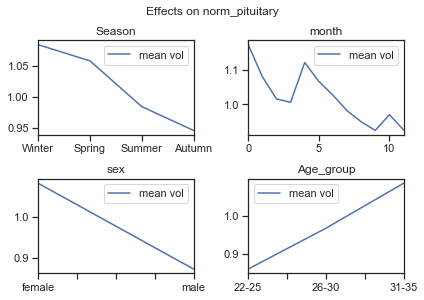

######### 2-WAY ANOVA #########


,Source,SS,DF,MS,F,p-unc,np2
0,Gender,1.121,1.0,1.121,32.139,5.990992e-08,0.158
1,Age_group,0.237,2.0,0.119,3.402,3.557514e-02,0.038
2,Gender * Age_group,0.080,2.0,0.040,1.152,3.183194e-01,0.013
3,Residual,5.966,171.0,0.035,NaN,NaN,NaN


###############################


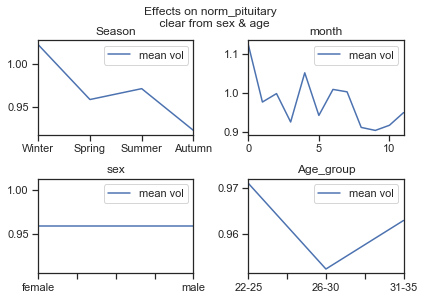

In [79]:
anova_2way_pituitary_seasonality()